# Drone and nondrone datasets exploration

In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


In [5]:
DRONE_DIR = "../../data/drone classification data/drone_dataset_npz"
NONDRONE_DIR = "../../data/drone classification data/nondrone_dataset_npz"

assert os.path.isdir(DRONE_DIR), f"Missing folder: {DRONE_DIR}"
assert os.path.isdir(NONDRONE_DIR), f"Missing folder: {NONDRONE_DIR}"


In [6]:
def list_npz_files(root_dir):
    files = []
    for f in os.listdir(root_dir):
        if f.lower().endswith(".npz"):
            files.append(os.path.join(root_dir, f))
    files.sort()
    return files


def safe_load_npz(path):
    """
    Loads .npz and returns (x, y, meta) or (None, None, None) if bad.
    meta is returned as a plain python dict when possible.
    """
    try:
        z = np.load(path, allow_pickle=True)
        x = z["x"]
        y = int(z["y"])
        meta = z["meta"].item() if isinstance(z["meta"], np.ndarray) else z["meta"]
        if not isinstance(meta, dict):
            meta = {"meta_raw": meta}
        return x, y, meta
    except Exception as e:
        return None, None, {"error": str(e), "source_file": path}


def quick_spec_plot(x, title=""):
    plt.figure()
    plt.imshow(x, aspect="auto", origin="lower")
    plt.title(title)
    plt.xlabel("time bins")
    plt.ylabel("freq bins")
    plt.colorbar()
    plt.show()


In [7]:
drone_files = list_npz_files(DRONE_DIR)
nondrone_files = list_npz_files(NONDRONE_DIR)

print("Drone .npz files:", len(drone_files))
print("Non-drone .npz files:", len(nondrone_files))


Drone .npz files: 11672
Non-drone .npz files: 12552


In [8]:
def scan_dataset(files, max_files=1000, name="dataset"):
    """
    Scans up to max_files for:
    - shape distribution
    - dtype distribution
    - NaNs/Infs
    - y distribution
    - meta fields distribution (dataset, tech, location, fs)
    """
    shapes = Counter()
    dtypes = Counter()
    labels = Counter()
    nan_count = 0
    inf_count = 0
    bad_files = []
    
    meta_dataset = Counter()
    meta_tech = Counter()
    meta_location = Counter()
    meta_fs = Counter()

    n = min(len(files), max_files)
    sample = files if len(files) <= max_files else random.sample(files, max_files)

    for p in sample:
        x, y, meta = safe_load_npz(p)
        if x is None:
            bad_files.append(meta)
            continue

        labels[y] += 1
        shapes[tuple(x.shape)] += 1
        dtypes[str(x.dtype)] += 1
        nan_count += int(np.isnan(x).any())
        inf_count += int(np.isinf(x).any())

        meta_dataset[meta.get("dataset", "unknown")] += 1
        meta_tech[meta.get("tech", "n/a")] += 1
        meta_location[meta.get("location", "n/a")] += 1

        fs = meta.get("fs", None)
        if fs is None:
            meta_fs["n/a"] += 1
        else:
            # bucket by MHz for readability
            try:
                mhz = round(float(fs) / 1e6, 3)
                meta_fs[f"{mhz} MHz"] += 1
            except:
                meta_fs["bad_fs"] += 1

    print(f"\n[{name}] scanned: {n} files")
    print(f"[{name}] label counts:", dict(labels))
    print(f"[{name}] top shapes:", shapes.most_common(5))
    print(f"[{name}] dtypes:", dict(dtypes))
    print(f"[{name}] files with NaNs:", nan_count)
    print(f"[{name}] files with Infs:", inf_count)
    print(f"[{name}] meta.dataset top:", meta_dataset.most_common(5))
    print(f"[{name}] meta.tech top:", meta_tech.most_common(5))
    print(f"[{name}] meta.location top:", meta_location.most_common(5))
    print(f"[{name}] meta.fs top:", meta_fs.most_common(5))

    if bad_files:
        print(f"[{name}] bad files:", len(bad_files))
        print("Example bad file:", bad_files[0])

    return {
        "labels": labels,
        "shapes": shapes,
        "dtypes": dtypes,
        "nan_files": nan_count,
        "inf_files": inf_count,
        "meta_dataset": meta_dataset,
        "meta_tech": meta_tech,
        "meta_location": meta_location,
        "meta_fs": meta_fs,
        "bad_files": bad_files,
    }


drone_scan = scan_dataset(drone_files, max_files=1000, name="DRONE")
nondrone_scan = scan_dataset(nondrone_files, max_files=1000, name="NON-DRONE")



[DRONE] scanned: 1000 files
[DRONE] label counts: {1: 1000}
[DRONE] top shapes: [((512, 17), 1000)]
[DRONE] dtypes: {'float32': 1000}
[DRONE] files with NaNs: 0
[DRONE] files with Infs: 0
[DRONE] meta.dataset top: [('AirID', 526), ('HoveringUAV', 474)]
[DRONE] meta.tech top: [('n/a', 1000)]
[DRONE] meta.location top: [('n/a', 1000)]
[DRONE] meta.fs top: [('10.0 MHz', 1000)]

[NON-DRONE] scanned: 1000 files
[NON-DRONE] label counts: {0: 1000}
[NON-DRONE] top shapes: [((512, 17), 1000)]
[NON-DRONE] dtypes: {'float32': 1000}
[NON-DRONE] files with NaNs: 0
[NON-DRONE] files with Infs: 0
[NON-DRONE] meta.dataset top: [('TechRecognition', 1000)]
[NON-DRONE] meta.tech top: [('lte', 369), ('dvbt', 348), ('wifi', 283)]
[NON-DRONE] meta.location top: [('rabot', 206), ('merelbeke', 190), ('reep', 170), ('gentbrugge', 150), ('uz', 149)]
[NON-DRONE] meta.fs top: [('1.0 MHz', 865), ('10.0 MHz', 135)]


Random DRONE spectrograms:


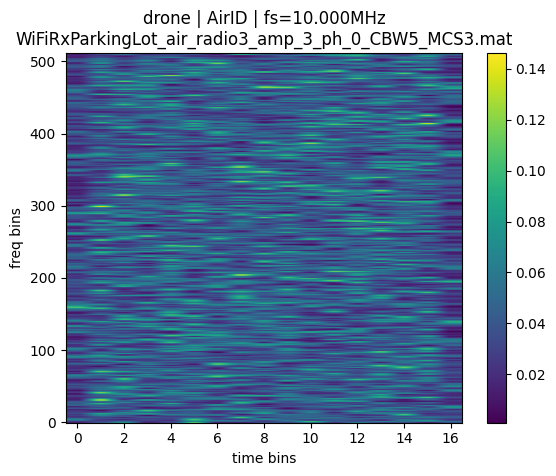

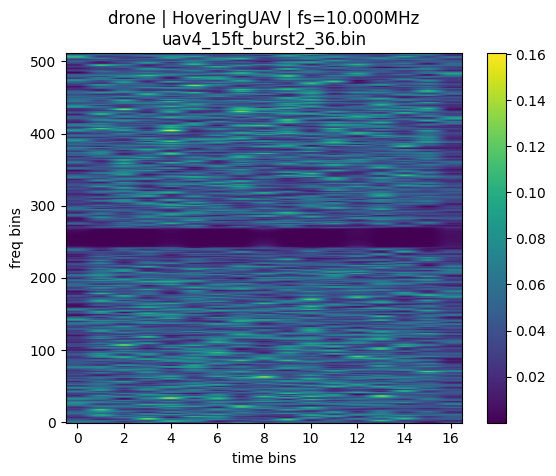

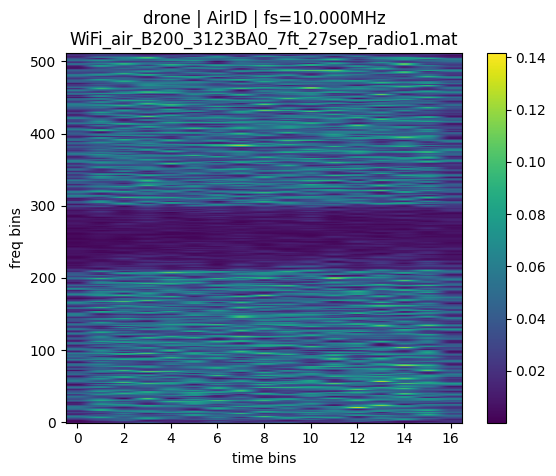

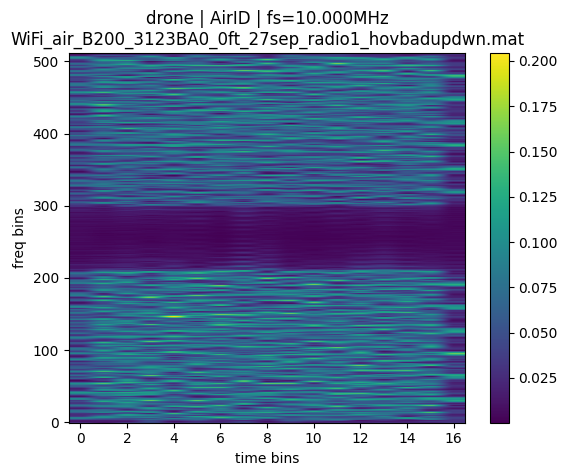

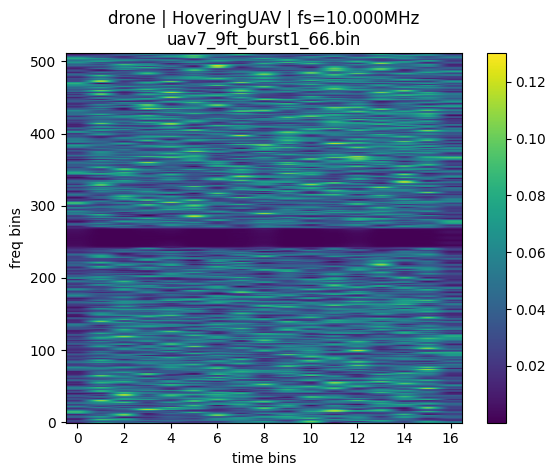

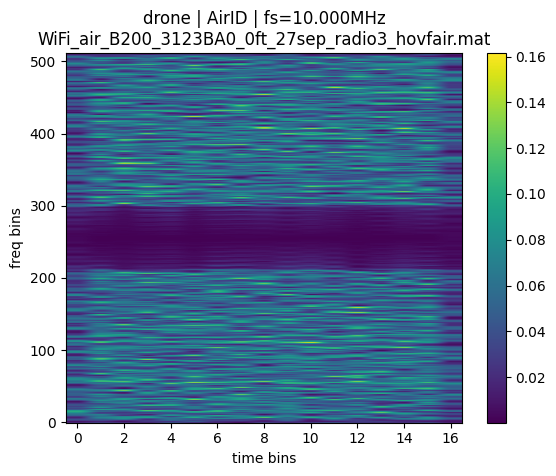

Random NON-DRONE spectrograms:


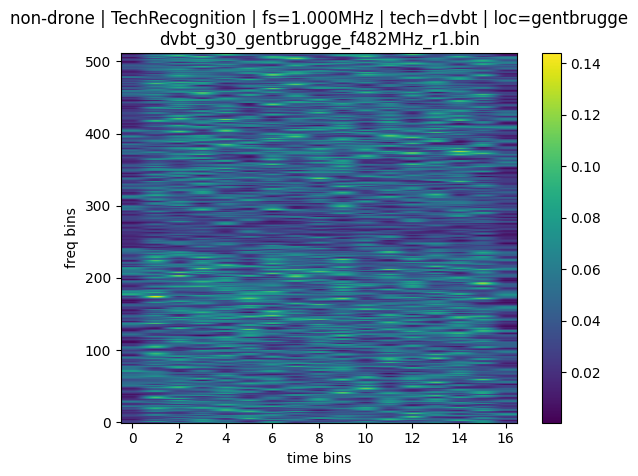

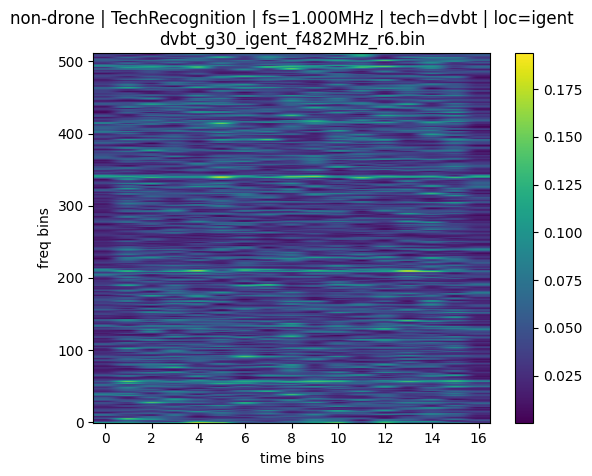

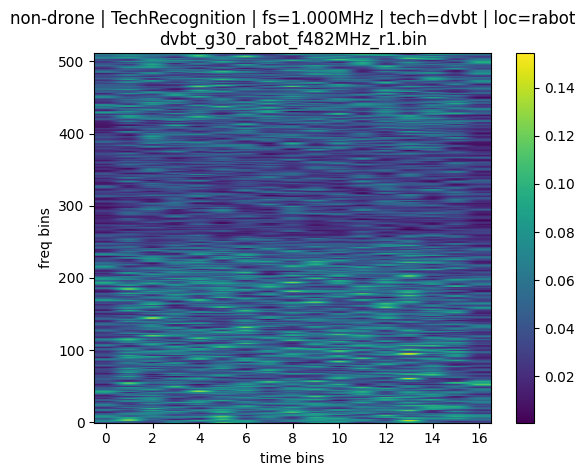

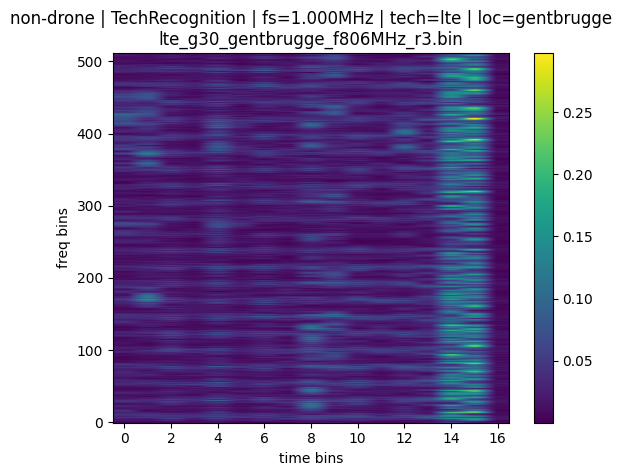

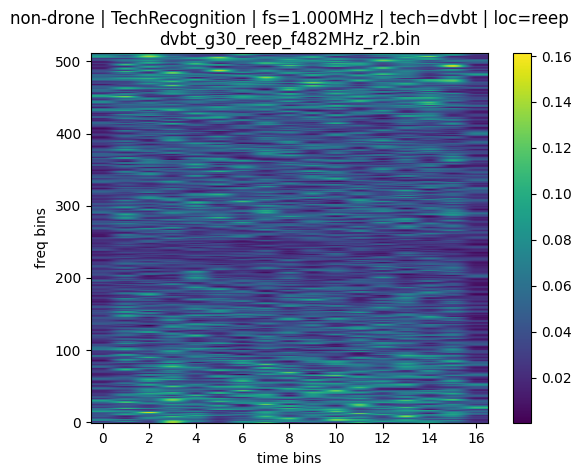

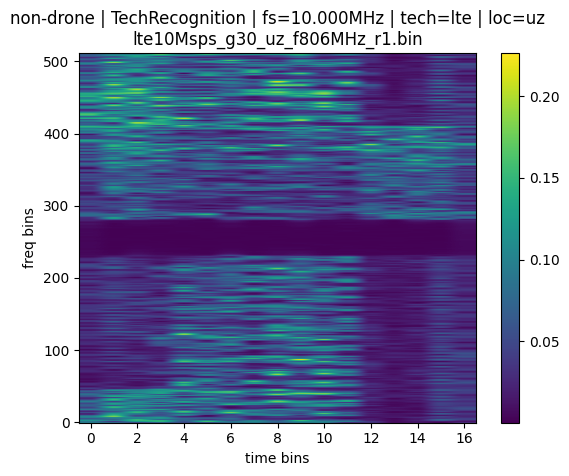

In [9]:
def show_random_examples(files, n=6, title_prefix=""):
    picks = files if len(files) <= n else random.sample(files, n)
    for p in picks:
        x, y, meta = safe_load_npz(p)
        if x is None:
            print("Bad file:", p, meta)
            continue

        src = os.path.basename(meta.get("source_file", p))
        ds = meta.get("dataset", "unknown")
        tech = meta.get("tech", "")
        loc = meta.get("location", "")
        fs = meta.get("fs", None)
        fs_str = f"{fs/1e6:.3f}MHz" if isinstance(fs, (int, float)) else str(fs)

        label_str = "drone" if y == 1 else "non-drone"
        extra = ""
        if tech and tech != "n/a":
            extra += f" | tech={tech}"
        if loc and loc != "n/a":
            extra += f" | loc={loc}"

        quick_spec_plot(
            x,
            title=f"{title_prefix}{label_str} | {ds} | fs={fs_str}{extra}\n{src}"
        )

print("Random DRONE spectrograms:")
show_random_examples(drone_files, n=6, title_prefix="")

print("Random NON-DRONE spectrograms:")
show_random_examples(nondrone_files, n=6, title_prefix="")
